In [1]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.acquisition import qLogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.likelihoods import GaussianLikelihood
import gpytorch
import win32com.client
from botorch.models.transforms import Normalize
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error
from scipy.stats import qmc
import os
import subprocess
from pathlib import Path
import time
import pandas as pd
import plotly.graph_objects as go

torch.set_default_dtype(torch.float64)

In [2]:

lower = [0.0, 5e-5, 1.0]           # Lower bounds for n, tau_star, B
upper = [1.0, 5000.0, 1.916e+19]   # Upper bounds for n, tau_star, B

log_lower_B = np.log10(lower[2])
log_upper_B = np.log10(upper[2])

sampler = qmc.LatinHypercube(d=3)
sample = sampler.random(5)  # 5 samples

# Scale the samples
n_values = sample[:, 0] * (upper[0] - lower[0]) + lower[0]
tau_star_values = sample[:, 1] * (upper[1] - lower[1]) + lower[1]
B_values = 10 ** (sample[:, 2] * (log_upper_B - log_lower_B) + log_lower_B)

# Save to CSV
LHS_data = pd.DataFrame({
    'n_values': n_values,
    'tau_star_values': tau_star_values,
    'B_values': B_values
})
LHS_data.to_csv('Viscosity.csv', index=False)


In [3]:
def calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp):
    common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=200)

    # Resample both curves on this time grid
    real_disp_resampled = np.interp(common_time, real_time, real_disp)
    guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)

    mse = np.mean((real_disp_resampled-guess_disp_resampled)**2)
    
    return mse

file_directory = Path("H:\\XMLFiles\\Visco")
real_data_directory = "H:\\Real_data\\visco_press_force_real.xml"
areas = []
area_data = []

real_tree = ET.parse(real_data_directory)
real_root = real_tree.getroot()
real_data = []
guess_data_all = {}

count = 0

for time_block, dept_block in zip(real_root.findall('.//Block//IndpVar'), real_root.findall('.//Block')):
    if count >=  27:
        break  # Stop the loop after collecting 27 values

    time_value = time_block.attrib.get('Value')
    dept_value = dept_block.find('DeptValues').text.strip()
    real_data.append((time_value, dept_value))

    count += 1

real_data_array = np.array([(float(x), float(y)) for x, y in real_data])
real_time = real_data_array[:, 0]  
real_disp = real_data_array[:, 1] * 0.0001019716

In [4]:
Synergy = win32com.client.Dispatch("synergy.Synergy")
Synergy.SetUnits("Metric")
moldflow = "C:\\Program Files\\Autodesk\\Moldflow Insight 2026\\bin"                        #Home D:\\Moldflow Insight 2023\\bin       #WS "C:\\Program Files\\Autodesk\\Moldflow Insight 2023\\bin"  #"G:\\Oskay Sözen\\wall_slip\\wall slip.mpi"


Synergy.OpenProject("G:\\Oskay Sözen\\viscosity\\viscosity.mpi")
Project = Synergy.Project
Project.OpenItemByName("50SurfaceCoverage_study", "Study")



# Simulation loop for wall slip parameters
for i in range(5):

    n = n_values[i]
    tau_star = tau_star_values[i]
    B = B_values[i]
    print(f"Simulation {i+1} with n : {n} tau_star : {tau_star} and B: {B}")

    study_name =f"visc_study_force_{i+1}"
    Project = Synergy.Project
    
    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    Prop.FieldDescription(53030, f"{n}, {tau_star}, {B}, 0.004, 2.412, 6.272, 0.305")
        
    PropEd.CommitChanges("Process Conditions")

    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)

    p = subprocess.Popen(
    [os.path.join(moldflow, "runstudy.exe"), f"G:\\Oskay Sözen\\viscosity\\visc_study_force_{i+1}.sdy"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()
    

    time.sleep(10)
    
    # Restart of the Synergy to prevent XML saving crash
    
    subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"]) 

    time.sleep(10)

    Synergy.OpenProject("G:\\Oskay Sözen\\viscosity\\viscosity.mpi")
    Project = Synergy.Project
    Project.OpenItemByName(f"visc_study_force_{i+1}", "Study")


    PlotMgr = Synergy.PlotManager
    time.sleep(10)
    Plot = PlotMgr.FindPlotByName2("Press force:XY Plot", "Press force")
    Pid = Plot.GetDataID
    PlotMgr = None
    PlotMgr = Synergy.PlotManager
    time.sleep(10)
    PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\Visco\\visc_study_force_{i + 1}.xml", "Metric")
    
    


    
# Write the output to a log file
    with open(f"H:\\Log_Files\\visc_study_force_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())

Simulation 1 with n : 0.7190811052578716 tau_star : 2275.003287449316 and B: 144409217.1451045
Simulation 2 with n : 0.828273510480854 tau_star : 4732.363180005843 and B: 1043084.6277377377
Simulation 3 with n : 0.5622362531651819 tau_star : 1107.9046598883203 and B: 4.877148235146452e+18
Simulation 4 with n : 0.1758728503297984 tau_star : 903.9723061386806 and B: 299894577373961.4
Simulation 5 with n : 0.25297449685502793 tau_star : 3839.065509846399 and B: 612.9315693167954


In [5]:
## CAREFUL ONLY APPEND 1 TIME
visc_valid_xml = []
for i in range(5):
        visc_guess_tree = ET.parse(f"H:\\XMLFiles\\Visco\\visc_study_force_{i + 1}.xml")
        visc_guess_root = visc_guess_tree.getroot()
        visc_guess_data = []

        count = 0
                
        for time_block, dept_block in zip(visc_guess_root.findall('.//Block//IndpVar'), visc_guess_root.findall('.//Block')):
                if count >= 27:
                        break


                time_value = time_block.attrib.get('Value')
                dept_value = dept_block.find('DeptValues').text.strip()
                visc_guess_data.append((time_value, dept_value))

                count += 1
        if len(visc_guess_data) < 27:
                print(f"Warning: File {i+1} has incomplete or corrupted data (only {len(visc_guess_data)} entries). Skipping.")
                continue

        guess_data_all[f"visc_guess_data_{i+1}"] = visc_guess_data

        guess_data_array = np.array([(float(x), float(y)) for x, y in visc_guess_data])
        visc_guess_time = guess_data_array[:, 0]  
        visc_guess_disp = guess_data_array[:, 1]

        globals()[f"guess_time_{i+1}"] = visc_guess_time
        globals()[f"guess_disp_{i+1}"] = visc_guess_disp


        mean_s_error = calculate_area_between_curves(real_time, real_disp, visc_guess_time, visc_guess_disp)
        area_data.append(mean_s_error)
        visc_valid_xml.append(len(area_data) - 1)

        
print(guess_data_all)


{'visc_guess_data_1': [('0.002000', '1.6645e+01'), ('0.018388', '2.1214e+01'), ('0.104796', '2.6517e+01'), ('0.176053', '1.4855e+02'), ('0.266708', '1.5024e+02'), ('0.404869', '1.3550e+02'), ('0.580162', '1.4994e+02'), ('0.705460', '1.5006e+02'), ('0.874578', '1.5003e+02'), ('1.005799', '1.5006e+02'), ('1.120493', '1.5038e+02'), ('1.242045', '1.5008e+02'), ('1.389637', '1.5005e+02'), ('1.506279', '1.5017e+02'), ('1.718897', '1.5008e+02'), ('1.882483', '1.5019e+02'), ('2.073834', '1.5016e+02'), ('2.242831', '1.5029e+02'), ('2.461990', '1.5017e+02'), ('2.649541', '1.5034e+02'), ('2.897116', '1.5025e+02'), ('3.121794', '1.5036e+02'), ('3.411878', '1.5028e+02'), ('3.656121', '1.5018e+02'), ('3.971417', '1.5043e+02'), ('4.455767', '1.5014e+02'), ('4.917627', '1.5103e+02')], 'visc_guess_data_2': [('0.002000', '8.4834e+00'), ('0.018388', '7.9437e+00'), ('0.104796', '9.6567e+00'), ('0.175870', '6.8870e+01'), ('0.238168', '1.4981e+02'), ('0.304238', '1.5036e+02'), ('0.393126', '1.5026e+02'), ('

In [10]:
print(real_disp)
print(area_data)

[ 12.77296262  13.35012187  15.50682121  54.79749841  93.54364726
 103.246245   111.57732472 123.21228428 132.95057208 145.18716408
 150.28574408 151.50940328 151.53999476 151.45841748 151.3768402
 151.50940328 151.50940328 151.33605156 151.3768402  151.48900896
 151.30546008 151.46861464 151.53999476 151.46861464 151.23407996
 151.05053108 151.06072824]
[np.float64(189.3666307733286), np.float64(122.04090510082027), np.float64(189.3666307733286), np.float64(7118.4392793090365), np.float64(20461.359419972614)]


In [7]:
print(area_data)
print(list(guess_data_all.keys()))
for name, lst in guess_data_all.items():
    array = np.array(lst)
    print(f"{name}: Shape = {array.shape}")

[np.float64(189.3666307733286), np.float64(122.04090510082027), np.float64(189.3666307733286), np.float64(7118.4392793090365), np.float64(20461.359419972614)]
['visc_guess_data_1', 'visc_guess_data_2', 'visc_guess_data_3', 'visc_guess_data_4', 'visc_guess_data_5']
visc_guess_data_1: Shape = (27, 2)
visc_guess_data_2: Shape = (27, 2)
visc_guess_data_3: Shape = (27, 2)
visc_guess_data_4: Shape = (27, 2)
visc_guess_data_5: Shape = (27, 2)


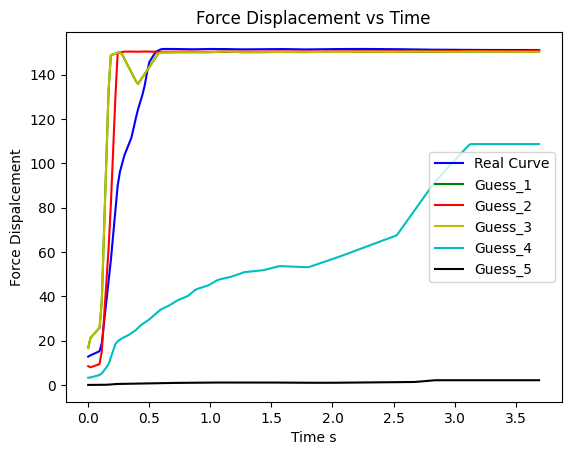

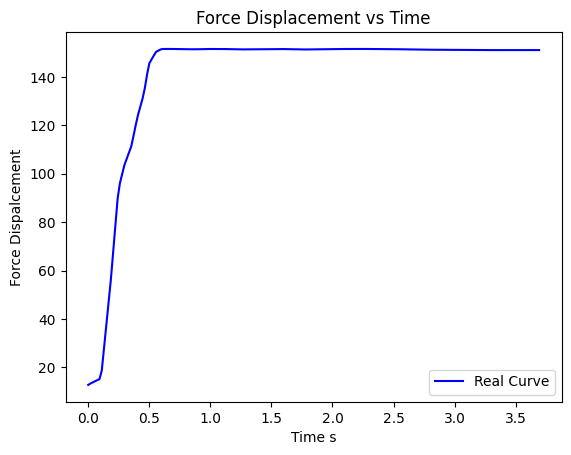

In [8]:
common_time = np.linspace(0.0, max(real_time.max(), visc_guess_time.max()), num=200)
real_disp_resampled = np.interp(common_time, real_time, real_disp)
guess_1_disp_resampled = np.interp(common_time, guess_time_1, guess_disp_1)
guess_2_disp_resampled = np.interp(common_time, guess_time_2, guess_disp_2)
guess_3_disp_resampled = np.interp(common_time, guess_time_3, guess_disp_3)
guess_4_disp_resampled = np.interp(common_time, guess_time_4, guess_disp_4)
guess_5_disp_resampled = np.interp(common_time, guess_time_5, guess_disp_5)
plt.plot(common_time, real_disp_resampled, 'b-', label = 'Real Curve')
plt.plot(common_time, guess_1_disp_resampled, 'g-',label = 'Guess_1' )
plt.plot(common_time, guess_2_disp_resampled, 'r-',label = 'Guess_2' )
plt.plot(common_time, guess_3_disp_resampled, 'y-',label = 'Guess_3' )
plt.plot(common_time, guess_4_disp_resampled, 'c-',label = 'Guess_4' )
plt.plot(common_time, guess_5_disp_resampled, 'k-',label = 'Guess_5' )
plt.legend(loc='best')
plt.xlabel('Time s')
plt.ylabel('Force Dispalcement')
# plt.ylim(1.84 ,1.88)
plt.title('Force Displacement vs Time')
plt.show()
plt.plot(common_time, real_disp_resampled, 'b-', label = 'Real Curve')
plt.legend(loc='best')
plt.xlabel('Time s')
plt.ylabel('Force Dispalcement')
plt.title('Force Displacement vs Time')
plt.show()


In [9]:
file_path = 'H:\\moldflow\\moldflow_automation\\Viscosity.csv'  
data = pd.read_csv(file_path)
n_values = data['n_values'].values
tau_star_values = data['tau_star_values'].values
B_values = data['B_values'].values
area_data_optimization = []
train_x = torch.tensor([[n_values[i], tau_star_values[i], B_values[i]] for i in visc_valid_xml], dtype=torch.float64)
train_y = -torch.tensor([[area_data[i]] for i in visc_valid_xml], dtype=torch.float64)
scale_factor = 1
train_y_scaled = train_y * scale_factor
train_yvar = torch.full_like(train_y_scaled, 1e-6)

# #tau_w_range = [0.001, 1] 0.001 , 2
# # #m_range = [0.5, 2]     0.1 , 2,5
# lower= [0.1, 1.0]
# upper = [5.0, 2.0]

# lower= [0.0001, 0.01]
# upper = [0.1, 1.0]

bounds = torch.tensor([
    [0.001, 0.1], 
    [1.0, 1.9]    
], dtype=torch.float64
)

outcome_transform = Standardize(m=1)
input_transform = Normalize(d=2)

# Optimization
model = SingleTaskGP(train_x, train_y_scaled,train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
model.eval()    

acq_func =  LogExpectedImprovement(model, best_f=train_y_scaled.max().item())
# acq_func =  qLogExpectedImprovement(model, best_f=train_y.max())

candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=1000, #Helps to ensure that we find the global optimum instead of finding the local optimum
        raw_samples=5000,  #More samples increases likelihood of finding good starting point.
)

cand = model(input_transform(candidate))
cand_var = torch.diagonal(cand.covariance_matrix, 0)
cand_mean, cand_std = outcome_transform.untransform(cand.mean, cand_var)

BotorchTensorDimensionError: Wrong input dimension. Received 3, expected 2.